In [1]:
%run init_notebookspace.py
from settings import DATA_DIR, MODEL_DIR, POST_EST_DIR, LATEX_OUT

DATA_DIR is existant under: C:\Users\LukasGrahl\Documents\GIT\memoire1\data


In [2]:
%matplotlib inline

from gEconpy.classes.model import gEconModel

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import xarray as xr
import pandas as pd

from itertools import chain
import os
import time

from scipy.stats import gamma, norm, beta, uniform
from filterpy.kalman import KalmanFilter


from src.plotting import plot_dfs
from src.process_data import load_data
from src.filtering_sampling import run_kalman_filter_forecast
from src.arima import get_arma_model
from src.utils import printProgBar, get_most_recent_mod_output, solve_updated_mod, get_most_recent_mod_output

from config import plt_config
plt.rcParams.update(plt_config)

load data

In [3]:
from config import fred_dict

df = load_data('prepro_data.csv', DATA_DIR, fred_dict)

# using real potential GDP instead of GDP
df = df.drop(['Ix', 'Zx', 'Y', 'pi_c', 'w'], axis=1).rename(columns={'Y_p': 'Y', 'pi_s': 'pi'})

Error occured 'pi_c', file_dict may be incomplete
Error occured 'S', file_dict may be incomplete
Error occured 'is_test', file_dict may be incomplete


In [4]:
df = df.loc[~df.S.isna()]

load & solve model

In [5]:
from config import mod4_params, mod4_priors, mod5_params, mod5_priors, mod6_params, mod6_priors
mods = {
    # 'mod4_rbc_vanilla': {'params': mod4_params,
    #                      'priors': mod4_priors,
    #                      'plot_vars': ['A', 'Y', 'C', 'I', 'L', 'K', 'w', 'r', 'lambda'],
    #                      'is_lin': False},
    # 'mod5_nk_vanilla': {'params': mod5_params,
    #                     'priors': mod5_priors,
    #                     'plot_vars': ['A', 'Y', 'C', 'I', 'L', 'w', 'r', 'pi', 'lambda'],
    #                     'is_lin': False},    
    'mod6_nk_energy_lin2': {'params': mod6_params,
                            'is_lin': True,
                            'priors': mod6_priors,
                            'plot_vars': ['S', 'Y', 'C']},
}

# load model
for key in mods.keys():
    # load
    mods[key]['mod'] = gEconModel(os.path.join(MODEL_DIR, f'{key}.gcn'), verbose=False)
    
    # solve
    _, mods[key]['mod'] = solve_updated_mod(mods[key]['mod'], model_is_linear=mods[key]['is_lin'], verbose=False)
    assert _ == True
    
    # get shocks
    mods[key]['shocks'] = [item.base_name for item in mods[key]['mod'].shocks]
    
    # load posterior estimates
    file_name = get_most_recent_mod_output(POST_EST_DIR, f'{key}_accepted')
    print(file_name)
    mods[key]['post_out'] = xr.open_dataset(os.path.join(POST_EST_DIR, file_name))

mod6_nk_energy_lin2_accepted_20230510_1823.nc


In [6]:
# Kalman filter forecast

In [28]:
mu_df_train

,CPI,C,S,Y,i,pi,r
date,,,,,,,
2000-07-01,0.000495,0.003491,0.028334,0.000495,0.003677,0.003343,0.007020
2000-10-01,0.000475,0.003164,0.027168,0.000475,0.003526,0.003205,0.006732
2001-01-01,0.000182,0.000777,0.010405,0.000182,0.001350,0.001228,0.002578
2001-04-01,0.000015,-0.000158,0.000831,0.000015,0.000108,0.000098,0.000206
2001-07-01,-0.000026,-0.000235,-0.001474,-0.000026,-0.000191,-0.000174,-0.000365
...,...,...,...,...,...,...,...
2020-07-01,-0.000706,-0.003569,-0.040402,-0.000706,-0.005244,-0.004767,-0.010011
2020-10-01,-0.000693,-0.004644,-0.039655,-0.000693,-0.005147,-0.004679,-0.009826
2021-01-01,-0.000426,-0.002457,-0.024356,-0.000426,-0.003161,-0.002874,-0.006035


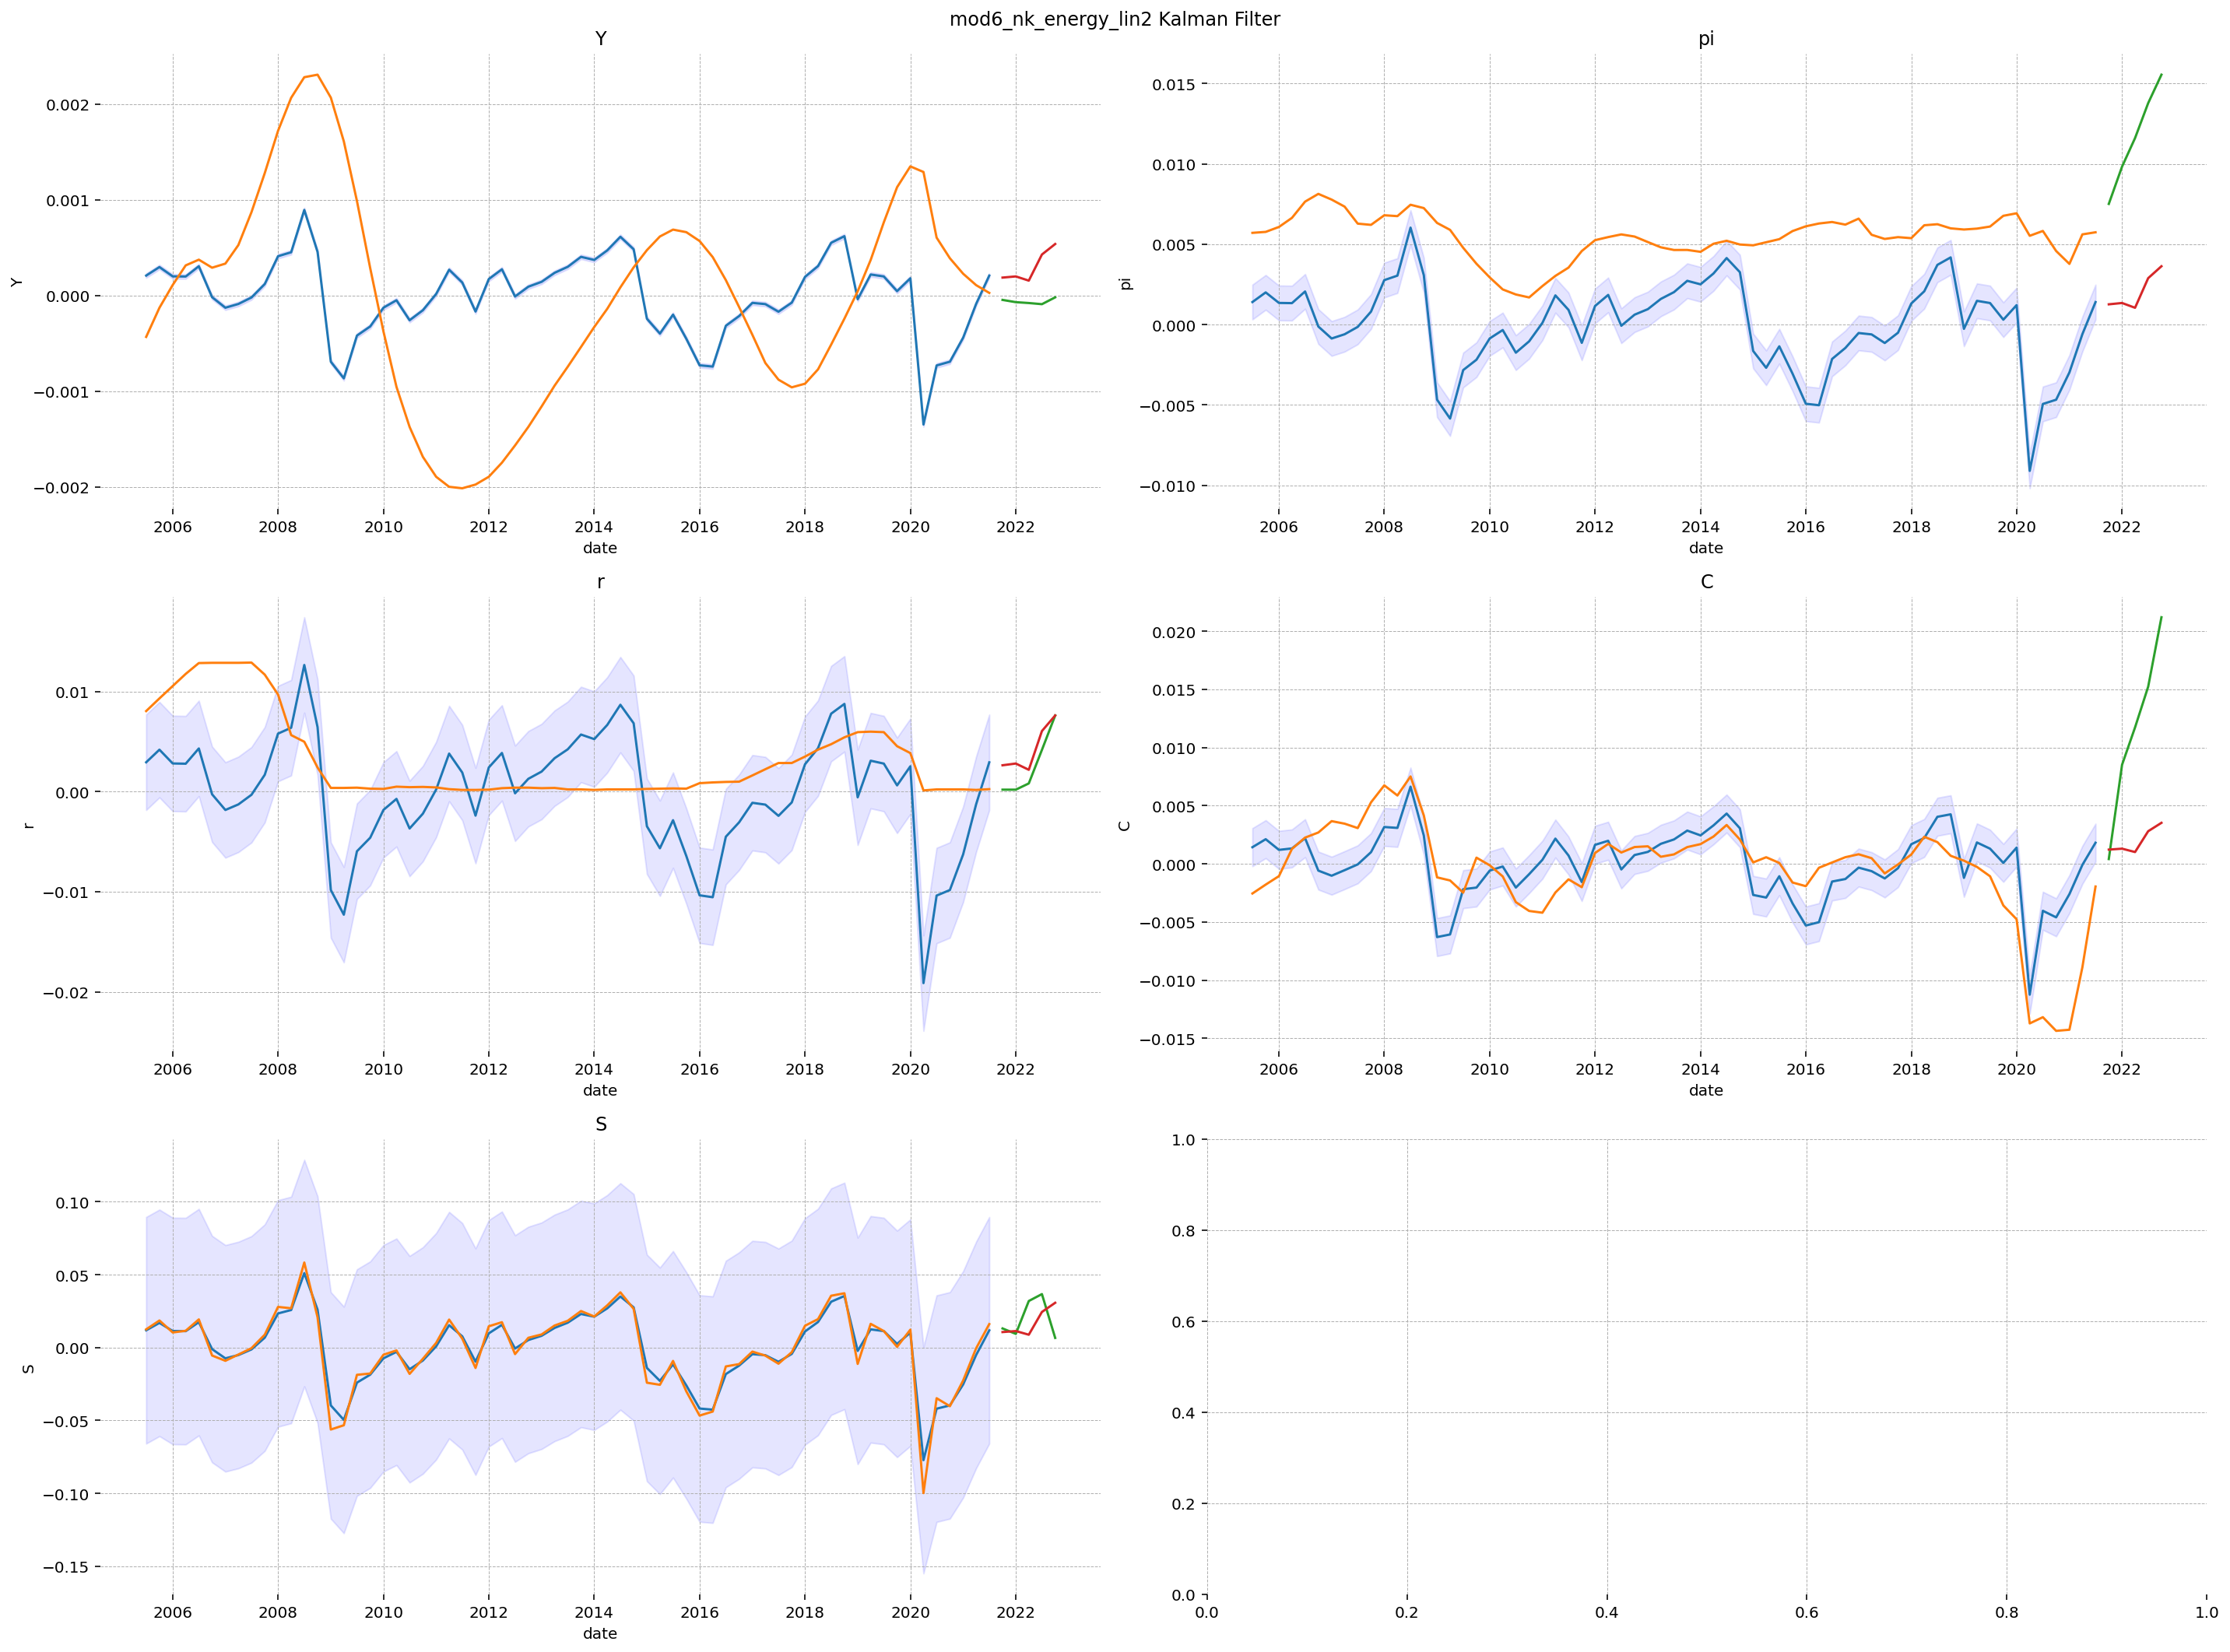

In [30]:
n_draws = 1
observed_vars = ["Y", "S"]
state_variables = [x.base_name for x in mod.variables]
total_vars = [item for item in df.columns if item in state_variables]
ind_plot_start = 20
observation_noise = .05

# get model attributes
name = 'mod6_nk_energy_lin2'

xarr = mods[name]['post_out'].copy()
mod = mods[name]['mod']
prior_dist = mods[name]['priors'].copy()
plot_vars = mods[name]['plot_vars'].copy()
mod_params = mods[name]['params'].copy()
mod_is_linear = mods[name]['is_lin']

# split train and test

train = df[df['is_test'] == False].copy() #[[col for col in observed_vars if col in df.columns]].copy()
test = df[df['is_test'] == True].copy() #[col for col in observed_vars if col in df.columns]].copy()


# get forecast
params = dict(zip(xarr.parameter.values, xarr.posterior_q2))
run_kalman_output = run_kalman_filter_forecast(mod, observed_vars, train[observed_vars], test[observed_vars], prior_dist, mod_params, params, observation_noise=observation_noise)
mu_df_train, cov_df_train, ll_test, mu_df_test, cov_df_test, ll_train = run_kalman_output

fig = plot_dfs(
    [mu_df_train[total_vars].iloc[ind_plot_start:], train[total_vars].iloc[ind_plot_start:], test[total_vars], mu_df_test[total_vars]],
    plotfunc=sns.lineplot, 
    dfs_cov=[*chain([cov_df_train[total_vars].iloc[ind_plot_start:]], [None] * (n_draws + 2))],
    # legend=['filter_train', 'data_train', 'filter_test', 'data_test'],
    cols=2,
    figsize=(20, 5),
    fig_title=f'{name} Kalman Filter',
)

fig.savefig(os.path.join(LATEX_OUT, f'{name}_kalman_forecast.png'))


mu_df_tests = []
for i in np.random.choice(xarr.draw, n_draws):
    params = dict(zip(xarr.parameter.values, xarr.sel(draw=i).posterior_param))
    _, _, _, mu_df_test, cov_df_test, ll_train = run_kalman_filter_forecast(mod, observed_vars, train[observed_vars], test[observed_vars], prior_dist, mod_params, params)
    mu_df_tests.append(mu_df_test[train[observed_vars].columns])


# plot results
# dfs = [mu_df_train[train.columns].iloc[ind_plot_start:], train.iloc[ind_plot_start:], test]
# dfs.extend(mu_df_tests)

# # plot_dfs(
#     dfs,
#     plotfunc=sns.lineplot, 
#     dfs_cov=[*chain([cov_df_train.iloc[ind_plot_start:]], [None] * (n_draws + 2))],
#     legend=['filter_train', 'data_train', 'filter_test', 'data_test'],
#     cols=2,
#     figsize=(20, 5),
#     fig_title=f'{name} Kalman Filter',
# )